# Классификация текстов с использованием Наивного Байесовского Классификатора

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from sklearn import metrics #метрики
from sklearn.metrics import roc_curve
from sklearn import model_selection
from sklearn.model_selection import train_test_split #разделение выборки

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB

In [3]:
%pip install plotly
import plotly
import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'


Note: you may need to restart the kernel to use updated packages.


In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [5]:
#откроем данные: 
email_data = pd.read_csv('/home/user/Загрузки/spam_or_not_spam.zip')
email_data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [6]:
email_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


Мы видим, что в признаке email есть нулевое значение. Чтобы это значение вошло в статистику, переведем значения в данном признаке в строку. 

In [7]:
# рассчитаем частоты для классов: 
freq = email_data.astype(str).groupby(by =['label'],as_index = False).count()
freq

,label,email
0,0,2500
1,1,500


In [8]:
# подготовим данные для визуализации
freq ['label'] = freq['label'].apply(lambda x: 'spam' if x=="1" else 'not_spam')
freq['email_ratio'] = round((freq['email']/freq['email'].sum()*100),1)
print(freq)

      label  email  email_ratio
0  not_spam   2500         83.3
1      spam    500         16.7


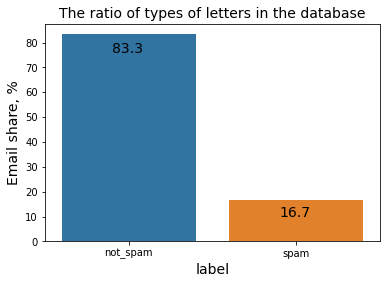

In [9]:
# визуализируем данные о соотношении типов писем
ax = sns.barplot(x=freq['label'], y=freq['email_ratio'], data = freq, ci= None);
ax.set_title("The ratio of types of letters in the database", fontsize=14)
ax.set_xlabel("label", fontsize=14)
ax.set_ylabel("Email share, %", fontsize=14)
plt.text(-0.1,76,freq.loc[0,'email_ratio'],fontsize=14)
plt.text(0.9,10,freq.loc[1,'email_ratio'],fontsize=14);

Вывод: Количество типов писем несбалансированно, требуется стратификация во время разделения выборки.

## Задание 2 (2 балла)

Предобработаем  данные и переведём их в векторный вид.

Заменим в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалим из данных все строки, в которых наблюдаются пропущенные значения.

In [10]:
email_data_clean = email_data.copy()
email_data_clean['email'] = email_data_clean['email'].replace(r'^\s*$', np.nan, regex = True).replace('', np.nan)

email_data_clean = email_data_clean.dropna()
email_data_clean.isnull().sum()

email    0
label    0
dtype: int64

Результат: Строки с пропущенными значениями удалены.

In [11]:
# Переведем данные в векторный вид:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(email_data_clean["email"])
X_array = X.toarray()
X_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [12]:
# Определим, сколько теперь признаков в нашем наборе данных:
X.shape

(2997, 34116)

## Задание 3 (2 балла)

In [13]:
# Определим целевую переменную и признаки:
y = email_data_clean['label'].astype(int)

In [14]:
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X_array, y, stratify = y, test_size=0.25, random_state=42)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2247, 34116)
Test shape: (750, 34116)


In [15]:
#Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

print('Train :', y_train.value_counts(normalize=True))
print('\n')
print('Test :', y_test.value_counts(normalize=True))

Train : 0    0.834001
1    0.165999
Name: label, dtype: float64


Test : 0    0.834667
1    0.165333
Name: label, dtype: float64


Результат: Классы сбалансированны.

## Задание 4 (3 балла)

In [16]:
# Используем для обучения алгоритм ComplementNB, т.к. этот алгоритм показывает высокое качество в задачах классификации текстов.
clf = ComplementNB(alpha=0.01)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [17]:
#Рассчитываем accuracy
print('Accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_pred)))
#Рассчитываем precision
print('Precision: {:.3f}'.format(metrics.precision_score(y_test, y_pred)))
#Рассчитываем recall
print('Recall: {:.3f}'.format(metrics.recall_score(y_test, y_pred)))
#Рассчитываем F1-меру
print('F1 score: {:.3f}'.format(metrics.f1_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.988
Precision: 1.000
Recall: 0.927
F1 score: 0.962
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       626
           1       1.00      0.93      0.96       124

    accuracy                           0.99       750
   macro avg       0.99      0.96      0.98       750
weighted avg       0.99      0.99      0.99       750



Действительно, алгоритм ComplementNB показывает высокое качество предсказаний, т.к. метрики на тестовой выборке близки к 1.00.
Тем не менее, сравним качество предсказаний с другим алгоритмом, работающим с текстами и несбалансированными выборками: MultinomialNB

In [18]:
# Применим алгоритм MultinomialNB
mlt = MultinomialNB(alpha=0.01)
mlt.fit(X_train, y_train)
y_pred_mlt = mlt.predict(X_test)

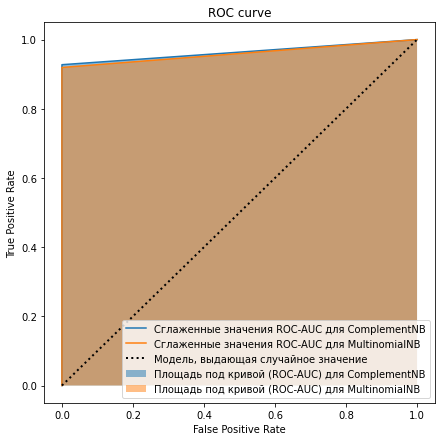

In [19]:
# Нарисуем ROC-кривую:
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, y_pred)
# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, 
         label='Сглаженные значения ROC-AUC для ComplementNB')

# Нарисуем ROC-кривую:
false_positive_rates_mlt, true_positive_rates_mlt, threshold_mlt = roc_curve(y_test, y_pred_mlt)

# рисуем кривую
plt.plot(false_positive_rates_mlt, true_positive_rates_mlt, 
         label='Сглаженные значения ROC-AUC для MultinomialNB')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates,
                 alpha=0.5, label='Площадь под кривой (ROC-AUC) для ComplementNB')

plt.fill_between(false_positive_rates_mlt, true_positive_rates_mlt,
                 alpha=0.5, label='Площадь под кривой (ROC-AUC) для MultinomialNB')

plt.legend()
plt.show()

In [20]:
auc = metrics. roc_auc_score (y_test, y_pred)
print(f"Площадь под кривой (ROC-AUC для ComplementNB): {round(auc,5)}")
auc_mlt = metrics. roc_auc_score (y_test, y_pred_mlt)
print(f"Площадь под кривой (ROC-AUC для MultinomialNB): {round(auc_mlt,5)}")

Площадь под кривой (ROC-AUC для ComplementNB): 0.96371
Площадь под кривой (ROC-AUC для MultinomialNB): 0.95968


Вывод: Изначальный выбор алгоритма классификации текста ComplementNB был верным, т.к. показатели точности прогнозирования, судя по площади под графиком ROC-AUC выше.
Однако это превышение небольшое, и показатели площадей под графиком ROC-AUC близки к единице, поэтому оба использованных алгоритма могут быть достаточно эффективными для решения поставленной задачи.

## Задание 5 (3 балла)

Переберём несколько значений alpha с помощью кросс-валидации для оценки, зависит ли от этого параметра качество классификации.
Для оценки будем использовать метрику F1-score, т.к. она дает обобщенное представление об метриках точности (Precision) и полноты(Recall).

In [21]:

#Создаем объект класса 
alpha_var = [0.01,0.1,0.5,1]
for num in alpha_var:
    model = ComplementNB(
    alpha = num)
#Создаём объект кросс-валидатора KFold
    kf = model_selection.StratifiedKFold(n_splits=5)

#Считаем метрики на кросс-валидации k-fold
    cv_metrics = model_selection.cross_validate(
        estimator=model, #модель
        X=X_train, #матрица наблюдений X
        y=y_train, #вектор ответов y
        cv=kf, #кросс-валидатор
        scoring='f1', #метрика
        return_train_score=True #подсчёт метрики на тренировочных фолдах
    )
    print(f"Коэффицент сглаживания alpha: {num}")
    print(f"Динамика значения метрики f1 на тестовом наборе данных {cv_metrics['test_score']} в зависимости от размера обучающей выборки")


Коэффицент сглаживания alpha: 0.01
Динамика значения метрики f1 на тестовом наборе данных [0.95172414 0.97986577 0.96551724 0.97260274 0.96551724] в зависимости от размера обучающей выборки
Коэффицент сглаживания alpha: 0.1
Динамика значения метрики f1 на тестовом наборе данных [0.95302013 0.98666667 0.96644295 0.96598639 0.97959184] в зависимости от размера обучающей выборки
Коэффицент сглаживания alpha: 0.5
Динамика значения метрики f1 на тестовом наборе данных [0.96       0.98013245 0.96644295 0.97959184 0.97297297] в зависимости от размера обучающей выборки
Коэффицент сглаживания alpha: 1
Динамика значения метрики f1 на тестовом наборе данных [0.95238095 0.98013245 0.96598639 0.97931034 0.97260274] в зависимости от размера обучающей выборки


Максимальное значение метрики f1 на тестовом наборе данных 0.97959184 соответствует коэффиценту сглаживания alpha: 0.1, однако это не говорит о том, что это в принципе наилучший уровень, ведь значения коэффицента сглаживания выбраны мною произвольно. 
Так же не наблюдается линейной зависимости между качеством предсказания и коэффицентом сглаживания. При увеличении этого коэффицента вначале наблюдается рост значения метрики, затем спад.
Чтобы увидеть эти эффекты воочию, построим кривые обучения.

In [22]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    """Функция строит кривые обучения

    Args:
        model (object type that implements the “fit” and “predict” methods): Используемая модель машинного обучения
        X (array-like of shape): матрица наблюдений X
        y (array-like of shape): вектор ответов y
        cv (int, cross-validation generator or an iterable): кросс-валидатор, default=None
        scoring_type_, optional (str or callable): метрика для оценки модели, default=None
        ax (AxesSubplot):координатная плоскость Defaults to None.
        title (str):Название графика
    """
    
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring="f1",  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0.5, 1)
    # Отображаем легенду
    ax.legend()

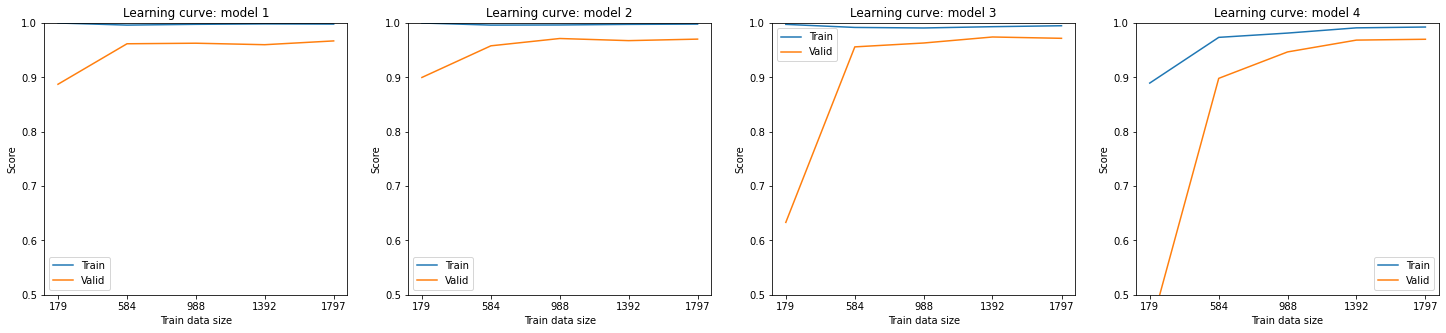

In [23]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
# Создаем список моделей с различными значениями коэффицента сглаживания alpha
models = [ComplementNB (alpha = 0.01), ComplementNB (alpha = 0.1), ComplementNB (alpha = 0.5), ComplementNB (alpha = 1)]
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 4, figsize=(25, 5)) #фигура + четыре координатных плоскости
#Создаём цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i — текущий индекс, model — текущая модель
    plot_learning_curve(model, X_train, y_train, skf, ax=axes[i], title=f'model {i+1}')

Выводы: Переобучения модели не наблюдается, расстояние между кривыми сравнительно небольшое и самое главное, тренировочная и валидационная кривые сходятся друг к другу и достигают приемлемого качества.
В целом, существенной разницы в качестве классификации модели между различными значениями коэффицента alpha не наблюдается, разница видна только от количества наблюдений в тренировочной базе данных.

In [24]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [25]:
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.1.0


In [26]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  alpha = trial.suggest_float('alpha', 0.01, 1,step=0.01,log=False)
 
  # создаем модель
  model = sklearn.naive_bayes.MultinomialNB(alpha = alpha)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_test, model.predict(X_test))

  return score

In [34]:
%%time
# cоздаем объект исследования

# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="MultinomialN", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

[I 2023-02-20 09:40:09,187] A new study created in memory with name: MultinomialN
[I 2023-02-20 09:40:15,970] Trial 0 finished with value: 0.979591836734694 and parameters: {'alpha': 0.25}. Best is trial 0 with value: 0.979591836734694.
[I 2023-02-20 09:40:23,041] Trial 1 finished with value: 0.983739837398374 and parameters: {'alpha': 0.16}. Best is trial 1 with value: 0.983739837398374.
[I 2023-02-20 09:40:28,605] Trial 2 finished with value: 0.979591836734694 and parameters: {'alpha': 0.38}. Best is trial 1 with value: 0.983739837398374.
[I 2023-02-20 09:40:33,711] Trial 3 finished with value: 0.979591836734694 and parameters: {'alpha': 0.79}. Best is trial 1 with value: 0.983739837398374.
[I 2023-02-20 09:40:39,103] Trial 4 finished with value: 0.979591836734694 and parameters: {'alpha': 0.43}. Best is trial 1 with value: 0.983739837398374.
[I 2023-02-20 09:40:45,925] Trial 5 finished with value: 0.979591836734694 and parameters: {'alpha': 0.44}. Best is trial 1 with value: 0.98373

CPU times: user 51.2 s, sys: 5.6 s, total: 56.8 s
Wall time: 1min 1s


In [35]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")